# Miniproject 2: Chatbot

## Introduction

### Description

Developing a model employing ANN on real-world data requires going through several major steps, each of which with 
important design choices that directly impact the final results. 
In this project, we guide you through these choices starting from a large database of 
[conversations](http://parl.ai/downloads/personachat/personachat.tgz) to a functional chatbot. 

### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "recurrent neural networks", "LSTM", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will be guided through a data processing procedure and understand the importance of design choices in ANN modeling
- You will learn how to define recurrent neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed in the lecture, like "overfitting", "LSTM network", and "Generative model".
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night and make sure you save (and load) your data and models.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook. 
Please ensure that your notebook is fully executed before handing it in. 

### Submission 

You should submit your notebook through the Moodle page submission tool. You should work in teams of two people and each member should submit the same notebook to Moodle.



## Functions and imports

For your convenience we import some libraries and provide some functions below. Fill in your names, sciper numbers and run the following cell.

In [2]:
names = {'student_1': "Fredrik Bixo",
        'student_2': "Pierre Armel Mbanga Ndjock"}

sciper = {'student_1': 300685, 
          'student_2': 229047}

seed = sciper['student_1']+sciper['student_2']

%matplotlib inline

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import os, sys
import copy

plt.rcParams['font.size'] = 28
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = False
c = plt.rcParams['axes.prop_cycle'].by_key()['color']

import keras
from keras.models import Model, load_model
from keras.layers import Input, Masking, TimeDistributed, Dense, Concatenate, Dropout, LSTM, GRU, SimpleRNN, Bidirectional, Embedding, BatchNormalization
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, EarlyStopping


def getRawDataFromFile(datapath="personachat/", file="train_both_revised.txt"):
    
    f = open(datapath+file)

    conversations = []
    current_conversation = []
    
    for l, line in enumerate(f):
        #print(l, line)
        if "persona:" in line:
            if len(current_conversation) > 1:
                conversations.append(current_conversation)
            current_conversation = [] 
            continue

        #remove numberings
        processed_line = line.split(' ')
        processed_line = " ".join(processed_line[1:])
        line = processed_line
        #print(line)

        conv = line.split('\t')    
        q = conv[0]
        a = conv[1]
        current_conversation.append(q)
        current_conversation.append(a)
    
    return conversations 



# Plotting

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history['loss'], label = "training")
    ax1.plot(history['val_loss'], label = "validation")
    ax2.plot(history['acc'], label = "training")
    ax2.plot(history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig

Using TensorFlow backend.


## Data visualization and preprocessing

Here we will process and visualize the data.


### Parse raw data 

Download the dataset on http://parl.ai/downloads/personachat/personachat.tgz. Unpack it and add it to your project folder. Read and run the getRawDataFromFile function (if needed, modify the default path). It extracts the conversations.

**Output** Display two randomly selected conversations. [1 pt]

In [3]:
conversations = getRawDataFromFile()

In [4]:
len(conversations)

8938

In [5]:
conversations[0]

['hi , how are you doing ? i am getting ready to do some cheetah chasing to stay in shape .',
 'you must be very fast . hunting is one of my favorite hobbies .',
 'i am ! for my hobby i like to do canning or some whittling .',
 'i also remodel homes when i am not out bow hunting .',
 'that is neat . when i was in high school i placed 6th in 100m dash !',
 'that is awesome . do you have a favorite season or time of year ?',
 'i do not . but i do have a favorite meat since that is all i eat exclusively .',
 'what is your favorite meat to eat ?',
 'i would have to say its prime rib . do you have any favorite foods ?',
 'i like chicken or macaroni and cheese .',
 'do you have anything planned for today ? i think i am going to do some canning .',
 'i am going to watch football . what are you canning ?',
 'i think i will can some jam . do you also play footfall for fun ?',
 'if i have time outside of hunting and remodeling homes . which is not much !']

In [6]:
sentences = [sentence for conv in conversations for sentence in conv]

In [7]:
separator = ' '

### Extract word tokens

Let's start looking at our data. 

**Code** Compute the set of unique words (dictionary) in all sentences along with the number of occurences of each of these words. HINT: each word is separated by a space character, use the python string.split(' ') function to separate words. Consider punctuations as 'words'. [1 pt]

**Figure** In a bar plot, show the first 75 most frequent words (x-axis) and their number of occurences (y-axis). [1 pt]

**Figure** In another bar plot, show the 75 least frequent words (x-axis) and their number of occurences (y-axis). [1 pt] 

**Figure** In a log-log scale, plot the sorted word index (x-axis) vs their respective count (y-axis). [1 pt]

**Question** Relate the sorted word count distribution with Zipf's law.
Argue using the log-log plot. [1 pt]

**Answer**

**Question** How many words appear only once in the entire dataset? [1 pt]

**Answer**



In [8]:
from collections import OrderedDict

In [9]:
word_dic = {} 

for conv in conversations:
    for sentence in conv:
        words = sentence.split(separator)
        for w in words:
            if w not in word_dic:
                word_dic[w] = 0
            word_dic[w] += 1

In [10]:
print('{:20} {:>06s}'.format('word', 'frequency'))
print('{:20} {:>06s}'.format('-'*20, '-'*6))
first_n = 10
for i, w in enumerate(word_dic.keys()):
    print('{:20} {:>06d}'.format(w, word_dic[w]))
    if not i < first_n:
        break

word                 frequency
-------------------- ------
hi                   004485
,                    039499
how                  010903
are                  017934
you                  048295
doing                004250
?                    043768
i                    103476
am                   024797
getting              000823
ready                000412


In [11]:
cut = 75

In [12]:
# top 75 words
print('{:20} {:>06s}'.format('word', 'frequency'))
print('{:20} {:>06s}'.format('-'*20, '-'*6))

top = OrderedDict(sorted(word_dic.items(), key=lambda kv: kv[1], reverse=True)[:cut])
for w in top.keys():
    print('{:20} {:>06d}'.format(w, top[w]))

word                 frequency
-------------------- ------
i                    103476
.                    101587
you                  048295
?                    043768
,                    039499
a                    034213
to                   032102
do                   030574
is                   028573
my                   026950
am                   024797
!                    023246
the                  021139
that                 020133
have                 018422
are                  017934
and                  016756
like                 016708
it                   014512
not                  014116
in                   013501
what                 013188
of                   012253
for                  011337
how                  010903
love                 010748
but                  008145
good                 008036
me                   007958
just                 007810
so                   007655
with                 007228
work                 006373
your             

In [13]:
# last 75 words
print('{:20} {:>06s}'.format('word', 'frequency'))
print('{:20} {:>06s}'.format('-'*20, '-'*6))

bottom = OrderedDict(sorted(word_dic.items(), key=lambda kv: kv[1], reverse=False)[:cut])
for w in bottom.keys():
    print('{:20} {:>06d}'.format(w, bottom[w]))

word                 frequency
-------------------- ------
100m                 000001
footfall             000001
mojitos              000001
asians               000001
taos                 000001
braids               000001
clot                 000001
breaker              000001
ventured             000001
smash                000001
whatsis              000001
whenso               000001
1960                 000001
secured              000001
michener             000001
churchill            000001
colombia             000001
hillbilly            000001
reel                 000001
ido                  000001
negatively           000001
gravity              000001
futurama             000001
forestry             000001
shibamotos           000001
providence           000001
omega                000001
togther              000001
jobless              000001
greenway             000001
yessir               000001
lantern              000001
laguna               000001
wanders          

In [13]:
plt.style.use('classic')

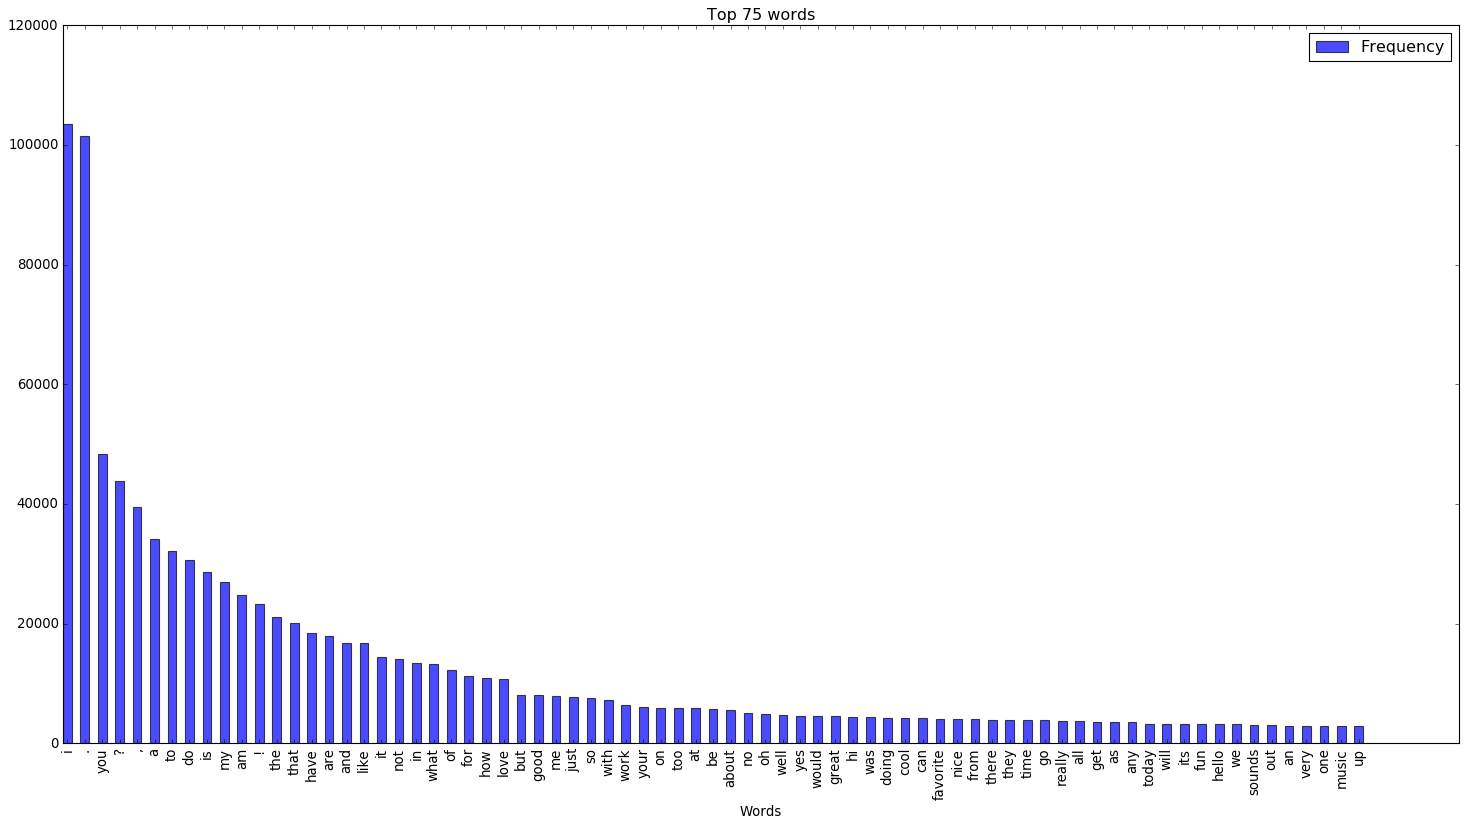

In [14]:
xs = np.arange(len(top))
ys = top.values()

bar_width = .5
opacity = 0.7
error_config = {'ecolor': '0.3'}


fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
fig.set_facecolor(color='white')


rects = ax.bar(xs, ys, width=bar_width,
               align='edge',
               alpha=opacity, color='b',
               error_kw=error_config,
               label='Frequency')

ax.set_xlabel('Words')
ax.set_title('Top 75 words')
ax.set_xticks(xs + bar_width / 2)
ax.set_xticklabels(top.keys())
ax.legend()

plt.xticks(rotation=90)
fig.tight_layout()


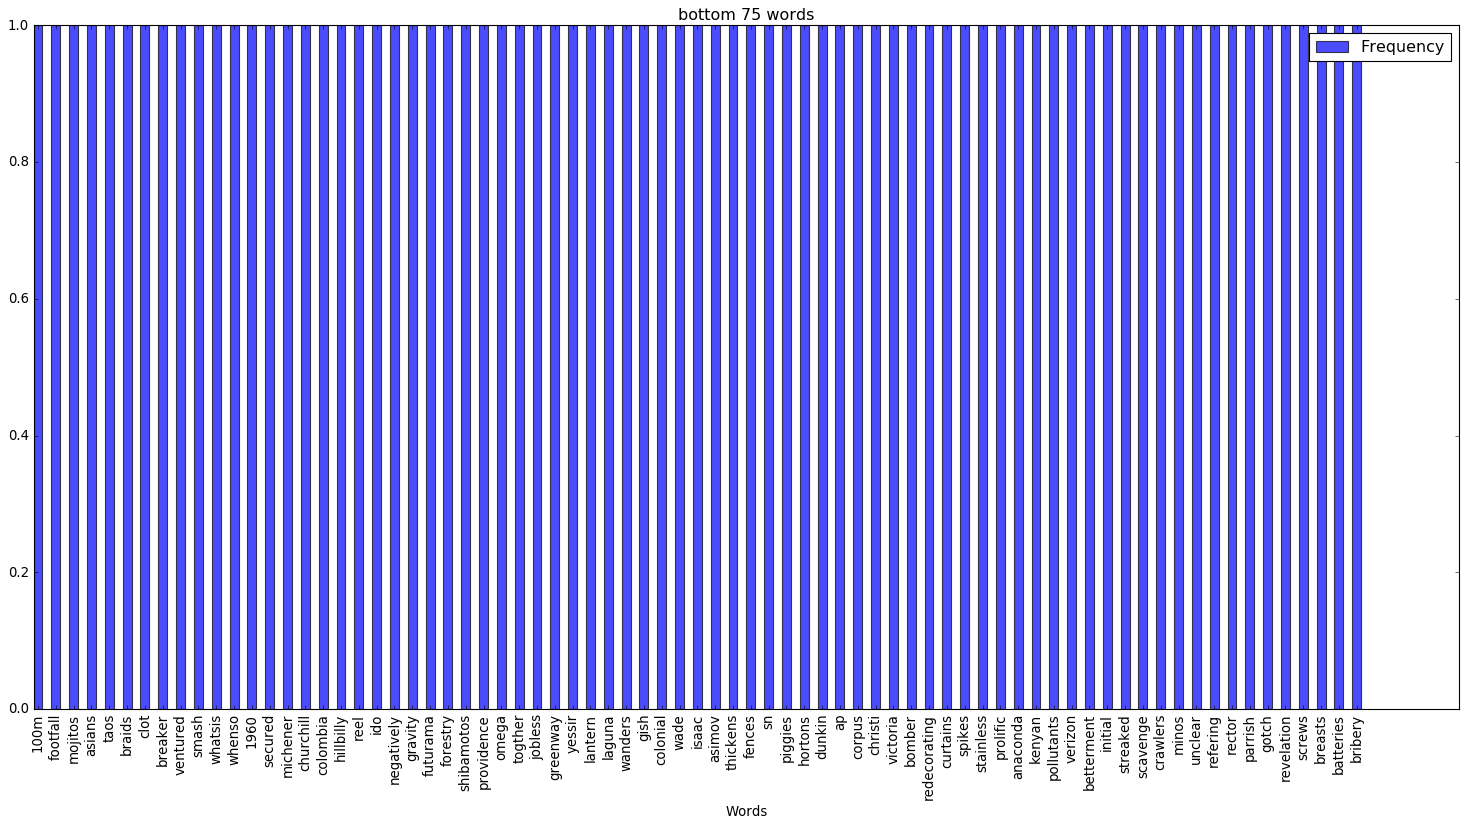

In [15]:
xs = np.arange(len(bottom))
ys = bottom.values()

bar_width = .5
opacity = 0.7
error_config = {'ecolor': '0.3'}

#plt.style.use('classic')

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
fig.set_facecolor(color='white')


rects = ax.bar(xs, ys, width=bar_width,
               align='edge',
               alpha=opacity, color='b',
               error_kw=error_config,
               label='Frequency')

ax.set_xlabel('Words')
ax.set_title('bottom 75 words')
ax.set_xticks(xs + bar_width / 2)
ax.set_xticklabels(bottom.keys())
ax.legend()

plt.xticks(rotation=90)
fig.tight_layout()

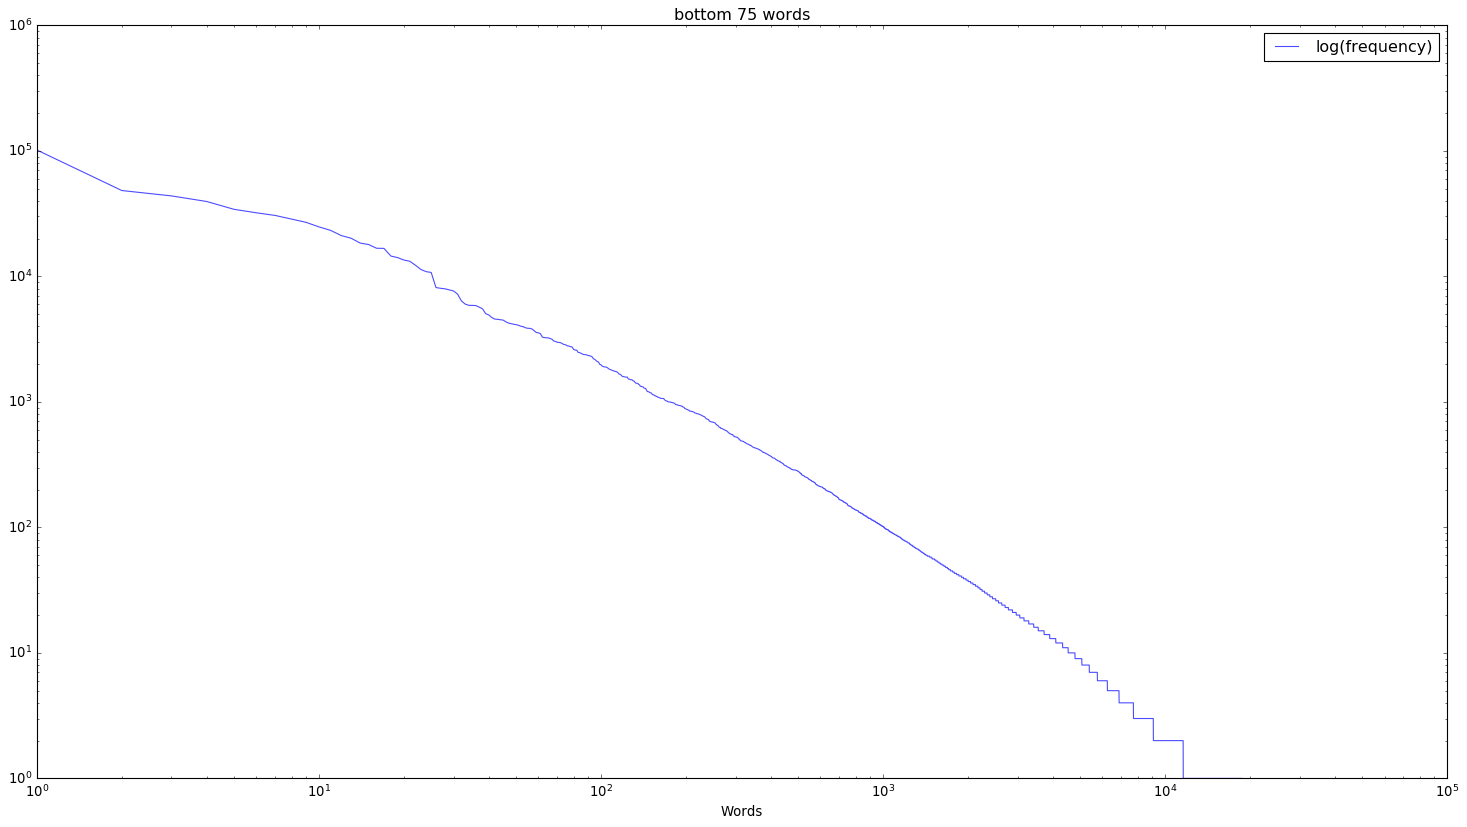

In [16]:
sort = OrderedDict(sorted(word_dic.items(), key=lambda kv: kv[1], reverse=True))

xs = np.arange(len(sort.keys()))
ys = sort.values()

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
fig.set_facecolor(color='white')

rects = ax.loglog(xs, ys, 
                alpha=opacity,
                color='b',
                label='log(frequency)')

ax.set_xlabel('Words')
ax.set_title('bottom 75 words')

ax.legend()

fig.tight_layout()

Since the graph is almost linear we can see that the word count follows a zipf distrubition. In other words, the most common word frequency is inversy proportional. So the most common word is multiplicative of the second most common word and so on.  

In [17]:
# How many words appear only once in the entire dataset ?
v = 1
values = np.array(list(word_dic.values()))
indices = np.where(values == v)
num = len(np.squeeze(indices))
print('there are {:d} words appearing only once in the entire dataset.'.format(num))

there are 7080 words appearing only once in the entire dataset.


### Filtering

We suggest to filter your data by removing sentences containing rare words. 


**Code** To achieve that, you should create a new dataset where sentences containing rare words (words that occur less than N times in the dataset) are removed. Keep at least 50'000 sentences (depending on your computing power, you can keep more). 
HINT: Start by updating the dictionary accordingly and then remove any sentence that contains at least a single word that is not in the dictionary of words. [2 pts]

**Question**: How much did you reduce the number of unique words with your rare event suppression procedure? [1 pt]
    
**Answer**: 18673 - 1293 = 17'380 words have been removed (93.08%)

**Question**: How many sentences are in your filtered and original dataset? [1 pt]

**Answer**: Original: 131424, Filtered: 58826

**Question**: What is the impact on learning and generalization of removing sentences with rare words from your dataset? [2 pt]

**Answer**: The generalization will be better because it will exclude rare words that probably was just occur in the training set and not in the test set.

In [42]:
# We keep only sentences where all word occurences in the
# dataset are above the predefined threshold
threshold = 70

In [43]:
# Update the vocabulary accordingly
dtype = np.dtype([('word','<U34'), ('frequency', int)])
word_array = np.array(list(word_dic.items()), dtype=dtype)
indices = np.squeeze(np.where(word_array['frequency'] >= threshold))

# new dictionary
freqword_dic = dict(word_array[indices])
# new array
freqword_array = word_array[indices]

In [44]:
freqword_set = set(freqword_dic.keys())
freqsentences = [s for s in sentences if set(s.split(separator)) <=  freqword_set]

In [45]:
print('{:^30s} |{:^20s} |{:^20s}'.format('', 'Original', 'Filtered'))
print('{:^30s} |{:^20s} |{:^20s}'.format('-'*30, '-'*20, '-'*20))
print('{:30s} |{:^20d} |{:^20d}'.format('# words', len(word_dic.keys()), len(freqword_dic.keys())))
print('{:30s} |{:^20d} |{:^20d}'.format('# sentences', len(sentences), len(freqsentences)))
print('\n')


w_prop = 100 * (1 - len(freqword_dic.keys()) / len(word_dic.keys()))
s_prop = 100 * (1 - len(freqsentences) / len(sentences))
print('{:^30s} |{:^20s} |{:^20s}'.format('', 'percentage', '#'))
print('{:^30s} |{:^20s} |{:^20s}'.format('-'*30, '-'*20, '-'*20))
print('{:30s} |{:^20.2f} |{:^20d}'.format('suppresed words', w_prop, len(word_dic.keys()) - len(freqword_dic.keys())))
print('{:30s} |{:^20.2f} |{:^20d}'.format('suppresed sentences', s_prop, len(sentences) - len(freqsentences)))

                               |      Original       |      Filtered      
------------------------------ |-------------------- |--------------------
# words                        |       18673         |        1293        
# sentences                    |       131424        |       58826        


                               |     percentage      |         #          
------------------------------ |-------------------- |--------------------
suppresed words                |       93.08         |       17380        
suppresed sentences            |       55.24         |       72598        


TODO:

By removing rare sentances with rare words, you may get better generalization before data points that are extreme and unusual are not considered. 

### Tokenization and padding

Now you will transform our filtered data into a format that is understandable by an ANN. To achieve that, you should transform words to integers, where single integers in the range [1,size of the dictionary] are mapped to single words in your dictionary. This process is commonly named 'tokenization'. In addition, we will keep the value 0 to a specific artificial word 'PADD' that will be used to account for the variable length of sentences and add to each sentence a 'START' and an 'END' word. 

**Code** Start by adding the three artificial words to your dictionary (list of possible tokens) and then translate every sentences to a list of integers. 
HINT: use the Python List index() method. [2 pts]

**Figure** Use the violinplot to show the density of tokenized sentences length. [1pt]

**Code** From this figure, select a maximum number (=maxlen) of tokens for which most of the sentences have less. Padd (and eventually truncate) all sentences with the 'PADD' token (value 0 in the integer representation) until all tokenized sentences have the same length (maxlen).
HINT: use the pad_sequences function from keras.preprocessing.sequence [2 pts]

**Code** Check that you can recover the original sentence. Randomly select two sentences from your integer and padded representation and translate them back using your dictionary. [1 pt]

In [46]:
word_dic, sentences = freqword_dic, freqsentences

In [47]:
# add the three artificial words
tokens = ['PADD'] + ['START'] + ['END'] + list(word_dic.keys())

No handles with labels found to put in legend.


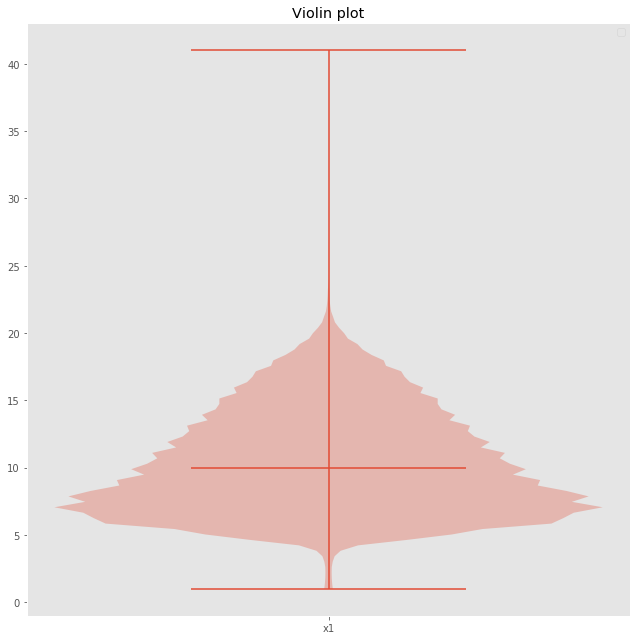

In [48]:
# Fixing random state for reproducibility
np.random.seed(19680801)
# lengths of sentences
xs = [len(s.split(separator)) for s in sentences]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 9))
ax.set_title('Violin plot')
ax.set_xticks([1])
ax.set_xticklabels(['x1'])
ax.legend()

ax.violinplot(xs,
              showmeans=False,
              showmedians=True)
fig.tight_layout()
plt.show()

In [49]:
# create dictionary of mappings
dic = dict(zip(tokens, range(len(tokens))))
# translate every sentence to a list of integer
isentences = []
for s in sentences:
    ints = [tokens.index('START')]
    for word in s.split(separator):
        ints += [tokens.index(word)]
    isentences += [ints + [tokens.index('END')]] 

In [56]:
# padd sequences of integers
isentences = pad_sequences(isentences, 
                           maxlen=max(xs), 
                           dtype='int32', 
                           padding='post', 
                           truncating='post', 
                           value=0)

# padd sequences of strings
psentences = pad_sequences([s.split(separator) for s in sentences], 
                              maxlen=max(xs), 
                              dtype='<U34', 
                              padding='post', 
                              truncating='post', 
                              value='PADD')
psentences = np.apply_along_axis(lambda s: separator.join(s), 1, psentences).tolist()

In [53]:
isentences[:2]

[[1, 7, 21, 22, 23, 24, 20, 25, 26, 27, 28, 29, 30, 31, 20, 2],
 [1, 41, 26, 46, 20, 15, 7, 47, 48, 30, 49, 36, 50, 28, 51, 9, 2]]

In [54]:
psentences[:2]

['you must be very fast . hunting is one of my favorite hobbies . PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD',
 'that is awesome . do you have a favorite season or time of year ? PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD']

In [55]:
def remove_flags_old(isentences):
    # mask padd values
    mask = ma.masked_where(isentences != 0, isentences)
    if np.any(np.logical_not(mask.mask)):
        # remove padd values
        isentences = isentences[mask.mask]
        # split on <START> => value = 1 (to recover original shape) 
        indices = np.where(isentences == 1)[0]
        # w/o padd
        isentences = np.split(isentences, indices)[1:]
    
    # remove <START>, <END> => [1, 2] values
    for i, s in enumerate(isentences):
        mask = np.isin(s, [1, 2])
        if np.any(mask):
            mask = np.logical_not(mask)
            isentences[i] = s[mask]
    return isentences

In [30]:
def remove_flags(isentences):
    # remove <PADD>, <START>, <END> => [0, 1, 2] values
    res = [0]*len(isentences)
    for i, s in enumerate(isentences):
        mask = np.isin(s, [0, 1, 2])
        res[i] = s
        if np.any(mask):   
            res[i] = s[np.logical_not(mask)]
    return res

In [31]:
def recover(isentences):
    # faster lookup
    dic_array = np.array(list(dic.items()), dtype=[('word','<U34'), ('id', int)])    
    # remove padding
    isentences = remove_flags(isentences)
    sentences = []
    for idx in isentences:
        sentences += [separator.join(dic_array['word'][idx])]
    return sentences

In [33]:
# Check that you can recover the original sentence.
n = len(isentences)
size = 2
selection = np.random.randint(n, size=size)

#print(isentences[selection])
#recover(isentences[selection])

### Saving

Now is a good time to save your data (end of processing). An example code using the pickle library is shown below.


In [14]:
import pickle
from pathlib import Path
from os.path import join

In [15]:
def save(filename, obj, save_path=Path('./save/')):
    pickle_out = open(join(save_path, Path(filename)), 'wb+')
    pickle.dump(obj, pickle_out, protocol=pickle.HIGHEST_PROTOCOL)
    pickle_out.close()
    return True

In [16]:
def load(filename, save_path=Path('./save/')):
    pickle_in = open(join(save_path, Path(filename)), 'rb')
    obj = pickle.load(pickle_in)
    pickle_in.close()
    return obj

In [17]:
# name space
name_frequencies = 'data/train_both_revised/word_dic.pkl' # dictionary {word: frequency}
name_psentences = 'data/train_both_revised/psentences.pkl'
name_isentences = 'data/train_both_revised/isentences.pkl' 
name_dictionary = 'data/train_both_revised/dic.pkl' # dictionary {token: id}
name_sentences = 'data/train_both_revised/sentences.pkl'

In [201]:
# save data
save(name_frequencies, word_dic)
save(name_psentences, psentences)
save(name_isentences, isentences)
save(name_dictionary, dic)
save(name_sentences, sentences)

True

In [202]:
# load data
word_dic = load(name_frequencies)
psentences = load(name_psentences)
isentences = load(name_isentences)
dic = load(name_dictionary)
sentences = load(name_sentences)

## Building and training generative models of language

### RNN vs LSTM vs GRU 

Build, train and compare generative models of language based on RNNs with different recurrent units (SimpleRNN, GRU and LSTM). 

The target of the network will be to approximate the word transition probabilities Pr(word[n+1]|H[n]) with H[n]=f(word[:n]) being the hidden state of the network.  

**code** You should complete the proposed model (using the Keras API rather than the Sequential model for more flexibility). Be sure to understand each line. The embedding layer allows to transform an integer to a dense vector. That would be our input to the recurrent network - each sentence is mapped to a sequence of vectors, each representing a single word. You can then design your own readout(s) and output layers. By default, use the proposed meta parameters. You can adapt them if you have more or less computing power (32 epochs should take around 30 minutes). [2 pts]

**Question** How will your networks deal with the artificial word 'PADD' that you added at the end of each sentences  [2 pts]

**Answer**

Todo

The embedding layer will mask the 0 and they will therefore be excludes from the network.

**code** Then train three different networks with the same architecture but using different recurrent units (simpleRNN, GRU and LSTM). Save the learning history (training/validation loss and accuracy for each epoch) as well as the models. [1 pt]

**Question** How can you use this network to approximate the word transition probabilities? What will be the inputs and targets of the network at each batch? Give the input/output tensor dimensions. [2 pts]

Todo

**Answer**

**Figure** Show the learning curves (training and validation loss) for the different recurrent units. [1 pt]

Done

**Figure** Show the learning curves (training and validation accuracy) for the different recurrent units. [1 pt]

Done

**Question:** Which recurrent unit yields the best validation accuracy? Which is the fastest learner? [1 pt]

GRU seems to have the best validationa accuracy. However, SimpleRNN requires less time to learn and is the fastest learner.

**Answer**: 

**Question:** Do you observe an overfitting effect? Where and for which case? Give a possible explanation. [1 pt] 

Yes, there is an overfitting effect. After around 5 epochs the validation accuracy and the accuracy starts to diverge. One reason that the data set starts to overfit, is because the training set is not very big compared to the total number possible sentances. Therefore, the network also starts to overfit.

**Answer**: 

**Question:** Suggest one option modifying your dataset to decrease overfitting. [1 pt]

One way to reduce the overfitting effect would be to either decrease the number of "rare" words. In this case the network will not try to model the outliers as much. Another way would be to increase the size of the dataset through data augumenation.

**Answer**: 

**Question:** Suggest one possible option modifying your network to decrease overfitting. [1 pt]

One way to modify the network to decrease overfitting would be to reduce the number of neurons in each layer. This will make the flexibility of the network decrease. This could be done either in the readout layer or the recurrent layer.

**Answer**: 

**Question:** Suggest one possible option modifying the training modalities to counter overfitting. [1 pt]   

**Answer**: We could use dropout or any other network or l2 regularization.

In [20]:
from keras.utils import plot_model, to_categorical
from math import ceil

In [58]:
#Meta-parameters
maxlen = 41
embedding_size = 128
hidden_size = 64
dropout = 0.2
recurrent_dropout = 0.2

batch_size = 128
epochs = 32
validation_split = 0.2

dataset_cut = int(.1 * len(isentences))

In [59]:
I = {}
E = {}
H = {}
R = {}
Y = {}
models = {}
logs = {}

In [60]:
def batch_iter(x, batch_size, num_batches=1):
    """
    Generate a minibatch iterator for a dataset.
    Takes as input one iterable (here the file names of the articles)
    Outputs an iterator which gives mini-batches of `batch_size` matching elements from `x`.
    Example of use :
    for minibatch_filenames, in batch_iter(x, 2):
        <DO-SOMETHING>
    """
    data_size = len(x)

    for batch_num in range(num_batches):
        start_index = batch_num * batch_size
        end_index = min((batch_num + 1) * batch_size, data_size)
        if start_index != end_index:
            yield x[start_index:end_index]

In [61]:
def prepare_data(isentences, split=.1):
    n = len(isentences)
    cut = int(split * n)
    
    x = []
    y = []
    
    # padd sequences of integers
    x2 = pad_sequences(isentences,   maxlen=maxlen, 
                           dtype='int32', 
                           padding='post', 
                           truncating='post', 
                           value=0)
    
    for s in x2:
        x.append(s[:-1])
        #One hot encode
        y2 = to_categorical(s[1:], len(tokens))
        y.append(y2)

    # convert to np array
    x = np.array(x)
    y = np.array(y)
    
    x_train, x_test = x[cut:], x[:cut]
    
    # convert to one hot encoding
    y_train, y_test = y[cut:], y[:cut]

    return (x_train, y_train), (x_test, y_test)

In [62]:
# Get data
(x_train, y_train), (x_test, y_test) = prepare_data(isentences)

In [ ]:
# LSTM

# Input
I['LSTM'] = Input(shape=(maxlen-1,), name="input")
# Transform every character into a 128-dimensional vector:
E['LSTM'] = Embedding(len(dic), embedding_size, mask_zero=True, name="embedding")(I['LSTM'])
# The RNN layer with dropout
H['LSTM'] = LSTM(hidden_size, activation='tanh', dropout=dropout, recurrent_dropout=recurrent_dropout, return_sequences=True)(E['LSTM'])

# The readout layer
R['LSTM'] = TimeDistributed(Dense(embedding_size, activation='sigmoid'))(H['LSTM'])

# The output layer 
Y['LSTM'] = TimeDistributed(Dense(len(dic), activation='softmax'))(R['LSTM'])

models['LSTM'] = Model(inputs = I['LSTM'], outputs = Y['LSTM'])
models['LSTM'].compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
models['LSTM'].summary()

logs['LSTM'] = models['LSTM'].fit(x_train, y_train, 
                                epochs=epochs, 
                                validation_split=validation_split, 
                                batch_size=batch_size).history

In [ ]:
# SimpleRNN

I['RNN'] = Input(shape=(maxlen-1,), name="input")
# Transform every character into a 128-dimensional vector:
E['RNN'] = Embedding(len(dic), embedding_size, mask_zero=True, name="embedding")(I['RNN'])
# The RNN layer with dropout
H['RNN'] = SimpleRNN(hidden_size, activation='tanh', dropout=dropout, recurrent_dropout=recurrent_dropout, return_sequences=True)(E['RNN'])

# The readout layer
R['RNN'] = TimeDistributed(Dense(embedding_size, activation='sigmoid'))(H['RNN'])

# The output layer 
Y['RNN'] = TimeDistributed(Dense(len(dic), activation='softmax'))(R['RNN'])

models['RNN'] = Model(inputs = I['RNN'], outputs = Y['RNN'])
models['RNN'].compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
models['RNN'].summary()

logs['RNN'] = models['RNN'].fit(x_train, y_train, 
                                epochs=epochs, 
                                validation_split=validation_split, 
                                batch_size=batch_size).history

In [63]:
# GRU

I['GRU'] = Input(shape=(maxlen-1,), name="input")
# Transform every character into a 128-dimensional vector:
E['GRU'] = Embedding(len(dic), embedding_size, mask_zero=True, name="embedding")

# The RNN layer with dropout
H['GRU'] = GRU(hidden_size, activation='tanh', dropout=dropout, recurrent_dropout=recurrent_dropout, return_sequences=True)(E['GRU'](I['GRU']))

# The readout layer
R['GRU'] = TimeDistributed(Dense(embedding_size, activation='sigmoid'))(H['GRU'])

# The output layer 
Y['GRU'] = TimeDistributed(Dense(len(dic), activation='softmax'))(R['GRU'])

models['GRU'] = Model(inputs = I['GRU'], outputs = Y['GRU'])
models['GRU'].compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
models['GRU'].summary()

logs['GRU'] = models['GRU'].fit(x_train, y_train, 
                                epochs=epochs, 
                                validation_split=validation_split, 
                                batch_size=batch_size).history

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 40)                0         
_________________________________________________________________
embedding (Embedding)        (None, 40, 128)           165888    
_________________________________________________________________
gru_1 (GRU)                  (None, 40, 64)            37056     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 40, 128)           8320      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 40, 1296)          167184    
Total params: 378,448
Trainable params: 378,448
Non-trainable params: 0
_________________________________________________________________
Train on 42355 samples, validate on 10589 samples
Epoch 1/32
25856/42355 [=================>............] - ETA: 48s - loss: 4.8991 - ac

KeyboardInterrupt: 

In [204]:
# Save models and layers
save('models/dict.pkl', [I,E,H,R,Y,models,logs])

TypeError: can't pickle _thread.RLock objects

In [137]:
plot_model(gru_model, to_file='gru_model.png')

In [203]:
# save
#save('models/rnn.pkl', [models['RNN'], logs['RNN'], x_train, y_train, x_test, y_test])

save('models/gru2.pkl', [models['GRU'], logs['GRU']])

#save('models/lstm.pkl', [models['LSTM'], logs['LSTM'], x_train, y_train, x_test, y_test])

True

In [18]:
# load
gru_model, gru_history = load('models/gru2.pkl')

In [ ]:
rnn_model, rnn_history = load('models/rnn.pkl')

In [ ]:
lstm_model, lstm_history = load('models/lstm.pkl')

In [ ]:
def viz(ix, iy, iyHat):
    # recover string representation
    
    syHat = recover(iyHat[:, None])
    sy = recover(iy[:, None])
    sx = recover(ix)
    
    print('{:^75s} |{:^15s} |{:^15s}'.format('input', 'target', 'prediction'))
    print('{:^75s} |{:^15s} |{:^15s}'.format('-'*75, '-'*15, '-'*15))
    
    for i, v in enumerate(zip(sx, sy, syHat)):
        input_, target, pred = v
        print('{:75s} |{:^15s} |{:^15s}'.format(input_, target, pred))
        if i == 100: 
            break

In [ ]:
def accuracy(model, ix, hy, show=True):
    # target: change one hot encoding back to integer
    iy = np.apply_along_axis(np.argmax, 1, hy)
    # compute predictions
    hyHat = model.predict(ix)
    # prediction: change one hot encoding back to integer
    iyHat = np.apply_along_axis(np.argmax, 1, hyHat)
    
    n_samples = len(iy)
    n_errors = len(np.nonzero(iy - iyHat)[0])
    # simple viz
    viz(ix, iy, iyHat) if show else None
        
    return 1 - n_errors / n_samples

In [154]:
#accuracy(rnn_model, x_test, y_test)
loss_and_metrics = gru_model.evaluate(x_test, y_test, batch_size=128)

5882/5882 [==============================] - 6s 968us/step


In [155]:
loss_and_metrics

[2.7847613611419115, 0.4189685562239825]

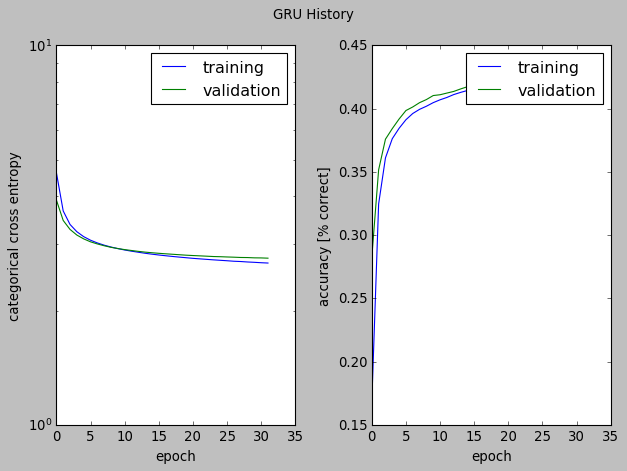

In [47]:
#Plot GRU history

plot = plot_history(gru_history, "GRU History")

In [ ]:
#Plot LSTM history

plot = plot_history(lstm_history, "LSTM History")

In [ ]:
#Plot SimpleRNN history

plot = plot_history(rnn_history, "SimpleRNN History")

In [156]:
plot_model(gru_model, to_file='gru_model.png', show_shapes=True)

In [ ]:
plot_model(lstm_model, to_file='lstm_model.png', show_shapes=True)

In [ ]:
plot_model(rnn_model, to_file='rnn_model.png', show_shapes=True)

### Optimal network size

Compare the learning curves for three networks with 64 (previous exercise), 128 and 256 GRUs (single layer) and one with two hidden layers of 64 GRUs. 

**Code** Build and train the networks. Apply EarlyStopping (monitor='val_acc', min_delta=0.001, patience=2). Use transfer learning, do not train from scratch your embedding layer, rather re-use the embedding layer from your best performing network in the last exercise. [4 pts]

**Figure** Show the learning curves (training and validation loss) for the four models. [1 pt]

**Figure** Show the learning curves (training and validation accuracy) for the four models. [1 pt]

**Question** List and briefly explain the differences in the learning curves for the different models? [2 pts]

**Answer**

**Question** What effect had EarlyStopping? Give one advantage and one drawback. [2 pts]

**Answer**

**Question** What is your best model? Why? [1 pt]

**Answer**



In [ ]:
# define the patience for EarlyStopping
patience = 2
# Define Early Stopping Callback
es = EarlyStopping(monitor='val_loss', verbose=1, patience=patience, min_delta=0.001)

In [ ]:
# 1 Layer, 64 Neurons GRU

(x_train, y_train), (x_test, y_test) = prepare_data(isentences)

I['GRU64'] = Input(shape=(maxlen-1,), name="input")
# Transform every character into a 128-dimensional vector:
#E['LSTM'] = Embedding(len(dic), embedding_size, mask_zero=True, name="embedding")(I['LSTM'])
print(E['GRU'])
E['GRU'].trainable = False
# The RNN layer with dropout
# Use the embedding layer from previous models (Transfer learning)
H['GRU64'] = GRU(64, activation='tanh', dropout=dropout, recurrent_dropout=recurrent_dropout, return_sequences=True)(E['GRU'](I['GRU64']))

# The readout layer
R['GRU64'] = TimeDistributed(Dense(embedding_size, activation='relu'))(H['GRU64'])

# The output layer 
Y['GRU64'] = TimeDistributed(Dense(len(dic), activation='softmax'))(R['GRU64'])

models['GRU64'] = Model(inputs = I['GRU64'], outputs = Y['GRU64'])
models['GRU64'].compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
models['GRU64'].summary()

logs['GRU64'] = models['GRU64'].fit(x_train, y_train, 
                                epochs=epochs, 
                                validation_split=validation_split, 
                                batch_size=batch_size, callbacks=[es]).history

In [ ]:
# 1 Layer, 128 Neurons GRU

(x_train, y_train), (x_test, y_test) = prepare_data(isentences)

I['GRU128'] = Input(shape=(maxlen-1,), name="input")
# Transform every character into a 128-dimensional vector:
#E['LSTM'] = Embedding(len(dic), embedding_size, mask_zero=True, name="embedding")(I['LSTM'])
print(E['GRU'])
E['GRU'].trainable = False
# The RNN layer with dropout
# Use the embedding layer from previous models (Transfer learning)
H['GRU128'] = GRU(128, activation='tanh', dropout=dropout, recurrent_dropout=recurrent_dropout, return_sequences=True)(E['GRU'](I['GRU128']))

# The readout layer
R['GRU128'] = TimeDistributed(Dense(embedding_size, activation='relu'))(H['GRU128'])

# The output layer 
Y['GRU128'] = TimeDistributed(Dense(len(dic), activation='softmax'))(R['GRU128'])

models['GRU128'] = Model(inputs = I['GRU128'], outputs = Y['GRU128'])
models['GRU128'].compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
models['GRU128'].summary()

logs['GRU128'] = models['GRU128'].fit(x_train, y_train, 
                                epochs=epochs, 
                                validation_split=validation_split, 
                                batch_size=batch_size, callbacks=[es]).history

In [ ]:
# 1 Layer, 256 Neurons GRU

(x_train, y_train), (x_test, y_test) = prepare_data(isentences)

I['GRU256'] = Input(shape=(maxlen-1,), name="input")
# Transform every character into a 128-dimensional vector:
#E['LSTM'] = Embedding(len(dic), embedding_size, mask_zero=True, name="embedding")(I['LSTM'])
print(E['GRU'])
E['GRU'].trainable = False
# The RNN layer with dropout
# Use the embedding layer from previous models (Transfer learning)
H['GRU256'] = GRU(256, activation='tanh', dropout=dropout, recurrent_dropout=recurrent_dropout, return_sequences=True)(E['GRU'](I['GRU256']))

# The readout layer
R['GRU256'] = TimeDistributed(Dense(embedding_size, activation='relu'))(H['GRU256'])

# The output layer 
Y['GRU256'] = TimeDistributed(Dense(len(dic), activation='softmax'))(R['GRU256'])

models['GRU256'] = Model(inputs = I['GRU256'], outputs = Y['GRU256'])
models['GRU256'].compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
models['GRU256'].summary()

logs['GRU256'] = models['GRU256'].fit(x_train, y_train, 
                                epochs=epochs, 
                                validation_split=validation_split, 
                                batch_size=batch_size, callbacks=[es]).history

In [ ]:
# 2 Layers, 64 Neurons GRU

(x_train, y_train), (x_test, y_test) = prepare_data(isentences)

I['GRU2x64'] = Input(shape=(maxlen-1,), name="input")
# Transform every character into a 128-dimensional vector:
#E['LSTM'] = Embedding(len(dic), embedding_size, mask_zero=True, name="embedding")(I['LSTM'])
print(E['GRU'])
E['GRU'].trainable = False
# The RNN layer with dropout
# Use the embedding layer from previous models (Transfer learning)
H['GRU2x64'] = GRU(64, activation='tanh', dropout=dropout, recurrent_dropout=recurrent_dropout, return_sequences=True)(E['GRU'](I['GRU2x64']))

H2 = GRU(64, activation='tanh', dropout=dropout, recurrent_dropout=recurrent_dropout, return_sequences=True)(H['GRU2x64'])
# The readout layer
R['GRU2x64'] = TimeDistributed(Dense(embedding_size, activation='relu'))(H2)

# The output layer 
Y['GRU2x64'] = TimeDistributed(Dense(len(dic), activation='softmax'))(R['GRU2x64'])

models['GRU2x64'] = Model(inputs = I['GRU2x64'], outputs = Y['GRU2x64'])
models['GRU2x64'].compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
models['GRU2x64'].summary()

logs['GRU2x64'] = models['GRU2x64'].fit(x_train, y_train, 
                                epochs=epochs, 
                                validation_split=validation_split, 
                                batch_size=batch_size, callbacks=[es]).history

### Generate sentences

Now you will generate new sentences from your best performing model.

**Code** To achieve that, use the provided sample function below to generate new sentences from your model. You should start by constructing a sentence that starts with the 'START' artificial word and all other words being the 'PADD' artificial word. Then sample the first word from the corresponding probabilities given by your model. Add this word to the sentence and continue like this until you sample the 'END' artificial word or the maximum sentence length. [2 pts]

**Code** Generate 10 sentences for different sampling temperature in [0., 0.25, 0.5, 0.75, 1., 1.5., 2.]. [1 pt]

**7 Figures** For each temperature, use matplotlib imshow to plot the probablities of every word in one generated sentence (and only these words) at each time step. y-axis should be the words that are present in the sentence. x-axis the timesteps and the imshow value the probabilities given by the model for all words in the sentence at each timestep. Use the a colormap where 0 is white, e.g. cmap='Greys'. [2 pts]

**Code** Finally, seed your model with two different beginnings of max 4 words and let it generate 10 possible continuations (use sampling temperature of 1.). [2 pts]

**Question** What is the effect of sampling temperature on the generated sentences? [1 pt]

**Answer** Tempratures determines how randomly the next word in the sentance should be chosen.

**Question** In terms of sampling a probability distribution, what does a sampling temperature of 0 corresponds to? [1 pt] 

If the sampling temprature is 0, there is no randomness involved, and the the word will highest probability will be selected.

**Answer**

**Question** In terms of sampling a probability distribution, what does a sampling temperature of 1. corresponds to? [1 pt] 

If the sampling temprature is 1, then the probabilities will not change because exp(ln(p)/1) = p. Therefore, the each word will be selected randomply with probability p.

**Answer**

**Question** In terms of sampling a probability distribution, what does a very high sampling temperature corresponds to? [1 pt]

**Answer** There is a higher chance that the words with low probability is chosen. I.e the words are chosen more or less uniformly.

**Question** Based on the plotted word probabilities, explain how a sentence is generated. [2 pts]

**Answer**

**Question** Do you observe timesteps with more than one word with non-zero probability? How do these probable words relate in terms of language? [1 pt]

**Answer**

In [175]:
def sample(preds, temperature=1.):
    # helper function to sample an index from a probability array
    if temperature == 0.:
        return np.argmax(preds)
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds)
    return np.argmax(probas)


In [176]:
def generate_sentance(temperature=1., sentance = []):
    
    unique, counts = np.unique(sentance, return_counts=True)
    counts = dict(zip(unique, counts))
    
    for x in range(counts[0]):
        # Predict the probabilties next possible words
        yHat = gru_model.predict(sentance)
        # Randomly sample a token
        sampled_token = sample(yHat[0][x],1)
        # Stop generating a sentance if sampling the END token
        if (sampled_token == 2):
            #print("END OF SENTANCE")
            break
        sentance[0][x+(len(sentance[0])-counts[0])] = sampled_token
    return sentance

temp = 0.1



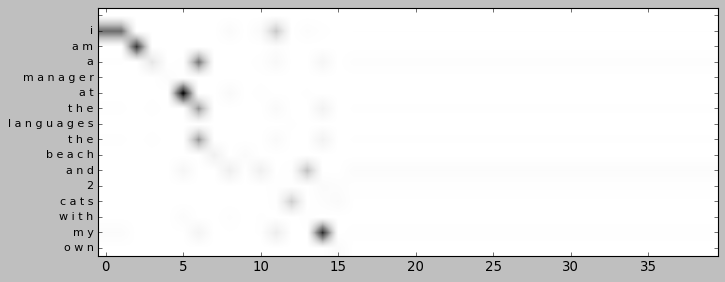

['i am a manager at the languages the beach and 2 cats with my own']
['i would not been early in the same way i do not wait for years eh']
['oh good . good day . funny !']
['awesome do you have a lot of friends']
['why are you still having good ?']
['good luck , too ! i am a best friend']
['i am crazy if you have any pet more hours all the time !']
['what is your favorite country singer ?']
['how are you doing today ?']
['that is awesome , just enjoying a band .']
temp = 0.25



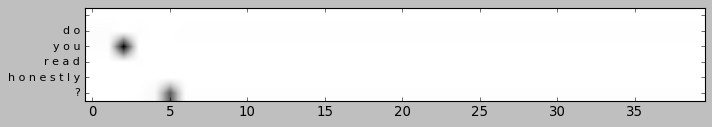

['do you read honestly ?']
['i don never think it is . 2 kids in 7 months .']
['cool are you born in from']
['i can enjoy it , since i am young']
['should that ! you could smell around people']
['i can love to walk most of the both of them']
['yes i cant laugh at law . so as long cats and you .']
['i fix dating gym , fun , i also like to go camping']
['i love winter ! what do you want to drink ?']
['pretty good talking to practice since my girlfriend and three dogs']
temp = 0.5



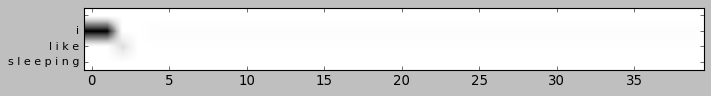

['i like sleeping']
['what is your career ? do you have siblings ?']
['what do you do for fun ?']
['i do not . i am home with pizza before .']
['yes , i live in the week but my three dogs do like country music .']
['sounds also on the weekends though']
['i love books too ! but i live working then']
['yum ! i am going to playing on tv from my garden .']
['pretty good ! thanks . its a great day !']
['yes me , what are their name ?']
temp = 0.75



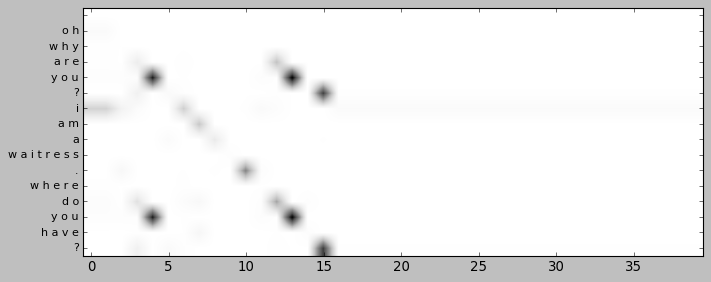

['oh why are you ? i am a waitress . where do you have ?']
['i am single all life by others so we can enjoy with that .']
['i am great . just got so happy to meet you']
['blue just too too bad , a book are pasta .']
['just the same full time as well .']
['that is too bad . could you play as a nurse !']
['never heard of it']
['i am sorry to hear that . huh ?']
['really ? it is creative ! what do you like ?']
['i am sorry . tell me about yourself ?']
temp = 1



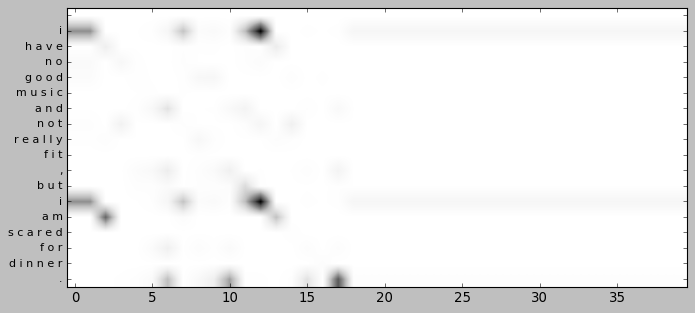

['i have no good music and not really fit , but i am scared for dinner .']
['that is french books when i feel , three and i love meat']
['sweet . i not tell the water are veggies .']
['i can go for many time . never over my life . you ?']
['haha what do you like to cook ?']
['great ! what do you do in your spare time ?']
['that is awful that is so nice . sorry to hear a new job']
['that sound lovely what else do you have from home ?']
['yeah we made with my blonde eyes']
['i have some part time at my black two dogs .']
temp = 1.5


KeyboardInterrupt: 

In [177]:
#Generate sentances for different tempratures

temps = [0.1, 0.25, 0.5, 0.75, 1, 1.5, 2]

for temp in temps:
    print("temp =",temp)
    for x in range(10):
        start_sentance = np.array([1] + [0]*39)[None, :]
        sentance = generate_sentance(temp, start_sentance)
        
        if x == 0:
        # Plot image:
            new_sentance = np.array([1] + [0]*39)[None, :]
            image = []
            i = 0
            words = []
        
            for word in sentance[0]:
                yHat = gru_model.predict(new_sentance)
                probs = []
                if word != 0:
                    words.append(recover([word])[0])
                
                for word2 in sentance[0]:
                    if word2 != 0:
                        probs.append(yHat[0][i][word2])
                new_sentance[0][i] = word
                i += 1
                image.append(probs)
                
            print()    
            fig, ax = plt.subplots(figsize=(10, 100))
            ax.imshow(np.array(image).transpose(), cmap='Greys')
            ax.set_yticks([i for i in range(len(words))])
            ax.set_yticklabels(words,fontsize=10)
            plt.show()
            
            #plt.imshow(np.array(image).transpose(), cmap='Greys')
            #plt.set_yticklabels(['hey','hey'])
            #plt.show()
        
        print(recover(sentance)) 
        
        
        

In [155]:
for _ in range(10):
    start_sentance = np.array([1 ,171 ,254, 99, 1015] + [0]*35)[None, :]
    sentance = generate_sentance(temp, start_sentance)
    print(recover(sentance)) 
    
for _ in range(10):
    start_sentance = np.array([1, 41, 26, 92] + [0]*36)[None, :]
    sentance = generate_sentance(temp, start_sentance)
    print(recover(sentance)) 

['at least the bar i least you song ! have love die in what a person later common you great ? in up ?']
['at least the bar where least some foot i do you you']
['at least the bar i usa , ocean ! love when when is it flowers you i i easier haha are watch have ! any']
['at least the bar i least you food for have like like then me 20 me it']
['at least the bar so least i only right have i find watch now the need an it']
['at least the bar that least you bank i is not say horses sometimes not . .']
['at least the bar that a my sea when they beer boyfriend season i are is .']
['at least the bar maybe least i evening . i you would at where may want have a i know . . bills eat what']
['at least the bar i least you is i love have guys vegan want swimming that .']
['at least the bar that all you snow i i did meet is love will not people good candy be see then places']
['that is good no is awesome . time anyone then i ! to . am']
['that is good why is fun . tell your']
['that is good hello might

In [ ]:
x = np.arange(1,10)
y1 = x
y2 = x*2
y3 = x*3

lines = [y1,y2,y3]
labels  = ['RED','GREEN','BLUE']

plotLines(lines,labels)

In [ ]:
# Testing

preds = np.asarray([0.2,0.8]).astype('float64')
preds = np.log(preds) / 1
print(preds)
exp_preds = np.exp(preds)
print(exp_preds)
preds = exp_preds / np.sum(exp_preds)
print(preds)
probas = np.random.multinomial(1, preds)
print(probas)

In [ ]:
dict_ = {0:0,1:0,2:0}

for i in range(10000):
    x = sample([0.2,0.2,0.6],100)
    #print(x)
    dict_[x] += 1
    
print(dict_)
    

###  Word embedding visualization

Here, you are asked to visualize the embedding layer. 

**Code** To do that, project in 2D the embedding vectors for different words. Use t-SNE, a projection that conserve the neighborhood relationships between vectors. HINT: Build a Keras model that takes as input a list of words and outputs a list of vector embeddings as learned by your best performing model. Use t-SNE dimensionality reduction (from sklearn.manifold import TSNE). [2 pts]

**Figure** Plot the projection of the first 200 most frequent words in a 2D plot. On the plot, write the words. [2 pt] 

**Question** Do you observe clusters of words with similar meaning or role in language? Report three of them here. [1 pt]

**Answer**

Yes, for example:

- and, or (logical connectives)
- haha, lol (Laughing words)
- fun, awesome, interesting, great, nice (Adjectives descriping how good something is)
- now, sometimes (Temporal words)

**Question** Why is having similar vector representation for similar words a good approach for such models? Explain using the example clusters from before and argue in terms of prediction accuracy and/or generalization. [2 pts]

**Answer**

If they have similar vector representation, that means that they are closer to each other in space. Because of this it's possible to create hyperplanes that seperate them into groups. In this way, there will be less overfitting because there will be one region for one type of words, instead of several regions that are spread out randomly. This means that the region will be smaller and therefore there will be less chance that other words not supposed to be in the region get missclassified.


In [115]:
# Get the top 200 words
top = OrderedDict(sorted(word_dic.items(), key=lambda kv: kv[1], reverse=True)[:200])

words = []
tokens = []

for w in top.keys():
    words.append(w)
    tokens.append(dic[w])

arr = np.array(tokens)
x_input = np.array([arr[:40], arr[40:80],arr[80:120],arr[120:160],arr[160:200]])

In [129]:
from sklearn.manifold import TSNE

MyInput = Input(shape=(41-1,), name="input")
MyEmbedding = gru_model.layers[1](MyInput)

model = Model(MyInput, MyEmbedding)
model.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
model.summary()

# Predict
y = model.predict(x_input)

# Concatinate the outputs
coordinates = np.concatenate((y[0],y[1],y[2],y[3],y[4]))

# Perform dimensionailty reduction.
X = np.array(coordinates)
X_embedded = TSNE(n_components=2).fit_transform(X)
X_embedded

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 40)                0         
_________________________________________________________________
embedding (Embedding)        (None, 40, 128)           165888    
Total params: 165,888
Trainable params: 165,888
Non-trainable params: 0
_________________________________________________________________
[[435  95 156 330 366 578 281  46  85 152 584 496 196 137 153  26 273 417
   71 160  81  19  92 206 544 280 357 575 591 348 396 150 146 279 212 273
  379 361 331 287]]
(5, 40, 128)


array([[-3.1928688e-01,  5.6919379e+00],
       [ 4.0969939e+00, -8.3168631e+00],
       [ 8.9934886e-01,  3.6943083e+00],
       [ 4.0861735e+00, -8.5288563e+00],
       [ 4.4489126e+00, -6.8005075e+00],
       [ 7.7172990e+00, -7.5784326e+00],
       [-7.7161107e+00,  3.8709109e+00],
       [-5.5665126e+00,  6.3448887e+00],
       [ 2.5077045e+00,  9.5101719e+00],
       [ 8.4585590e+00, -6.8819623e+00],
       [-4.4454840e-01, -7.6883574e+00],
       [ 4.1008549e+00, -8.3675203e+00],
       [ 7.7982898e+00, -7.1132121e+00],
       [ 5.1161880e+00,  4.0455194e+00],
       [-2.5249064e+00,  7.4621954e+00],
       [ 2.3322890e+00,  9.9011889e+00],
       [-9.8393254e-02,  9.2025785e+00],
       [-5.0451636e+00,  3.1118894e+00],
       [ 2.0191631e+00,  1.6636846e+00],
       [ 1.3369912e+00, -3.8010924e+00],
       [-5.8614235e+00, -1.5434423e-01],
       [-4.1699409e+00, -4.3588758e+00],
       [-6.7857709e+00,  2.4341900e+00],
       [-7.2164917e+00,  3.1047974e+00],
       [-3.43987

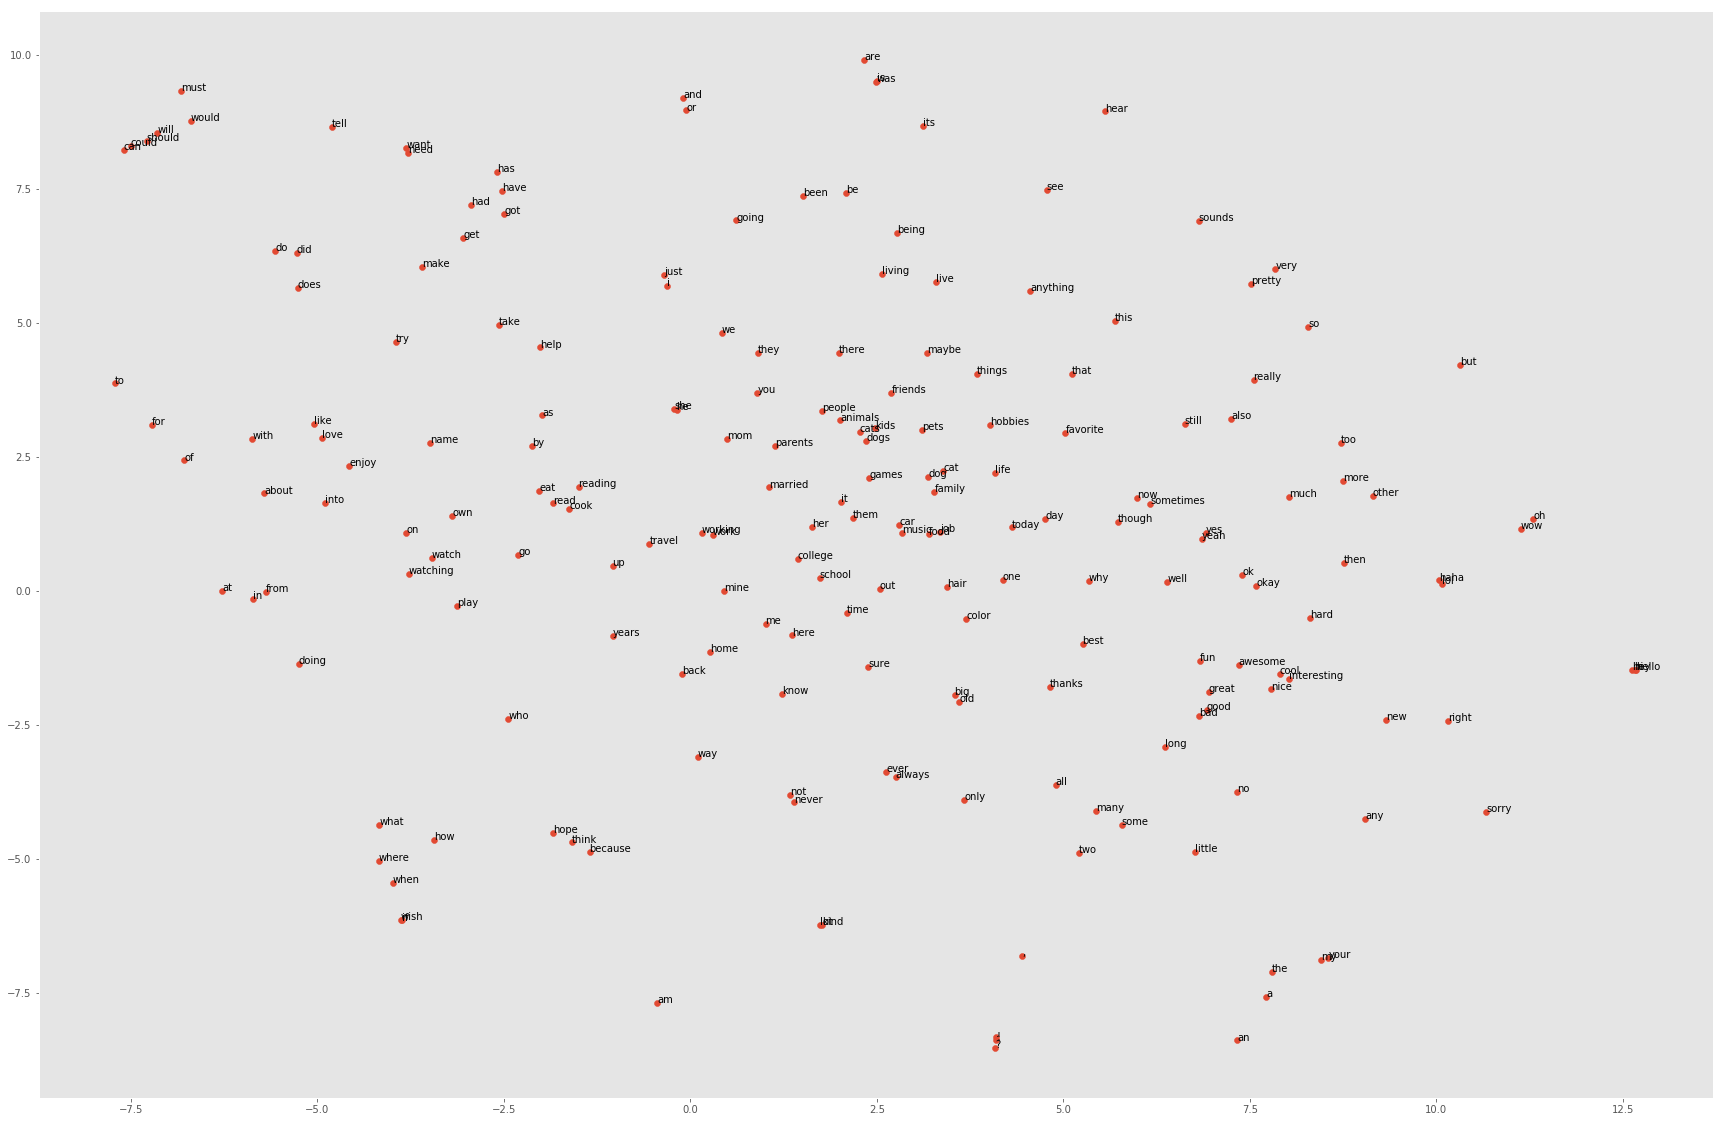

In [136]:
import matplotlib.pyplot as plt

#Plot
fig, ax = plt.subplots(figsize=(30,20))
ax.scatter(x_, y_)

for i, txt in enumerate(words):
    ax.annotate(txt, (x_[i], y_[i]))

## Chatbot

Finally, you will construct a model with which you can chat. The network will take as input a sentence and output a response.

**Code** For that, you should go back to your original data and construct a new dataset containing pairs of sentences, where each pair is a sentence and its answer. Be careful to not include any pair of sentences that contains words not present in your filtered dictionary. [2 pts]

**Code** You should then tokenize, padd, truncate each sentence. Only the answers need the 'START' and 'END' artificial words. [1 pt]

We provide you with a possible model, you are welcome to change it. This model uses an LSTM layer to encode the first sentence (the context). The final state of this LSTM layer is transfered to initialize the state of a decoder LSTM layer from which the answer sentence will be generated. 

**Code** Train your chatbot model on your dataset. [1 pt]

**Code** Adapt your sentence generation code from before so that you can generate an answer given a context sentence from your model. [2 pts] 

**Code** After training, randomly select 10 context-answers pairs from your data and show both the real answer (the one from the data) and the generated one for two different sampling temperatures (e.g. 0.5 and 1.0). [2 pts]

**Question** How similar are the generated answers and the real ones? Does your model provide probable answers (given the dataset)? Report here one good and one bad example. [2 pts]

**Answer**

**Question** Which sampling temperature gives better answers? why? [2 pts]

**Answer**

**Question** Would it be good if your model was able to reproduce exactly each real answer? Why? [1 pt]

**Answer**

**Code** Entertain yourself with your model. Write some code to chat with your bot, let it discuss with itself, ... be creative! [2 **bonus** pts]




In [139]:
context = Input(shape=(maxlen-2,), name="input_context")
shared_embedding = E['GRU']
context_embedding = shared_embedding(context)

encoder_y, encoder_h, encoder_c = LSTM(hidden_size, 
            return_sequences=False,
            return_state=True,
            stateful=False,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            go_backwards=True,
            name="encoder")(context_embedding)

answer = Input(shape=(maxlen-1,), name="input_answer")
answer_embedding = shared_embedding(answer)

decoder_input = answer_embedding
decoder = LSTM(hidden_size, 
            return_sequences=True,
            stateful=False,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            name="decoder")(answer_embedding, initial_state=[encoder_h, encoder_c])
# decoder2 = LSTM(hidden_size, 
#             return_sequences=True,
#             stateful=False,
#             dropout=dropout,
#             recurrent_dropout=recurrent_dropout,
#             name="decoder2")(decoder)

R = TimeDistributed(Dense(embedding_size, activation='relu'), name='readout')(decoder)
Y = TimeDistributed(Dense(len(tokens), activation='softmax'), name='output')(R)

Chatbot = Model(inputs = [context, answer], outputs = [Y])
Chatbot.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
Chatbot.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_answer (InputLayer)       (None, 40)           0                                            
__________________________________________________________________________________________________
input_context (InputLayer)      (None, 39)           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           multiple             165888      input_context[0][0]              
                                                                 input_answer[0][0]               
__________________________________________________________________________________________________
encoder (LSTM)                  [(None, 64), (None,  49408       embedding[1][0]                  
__________

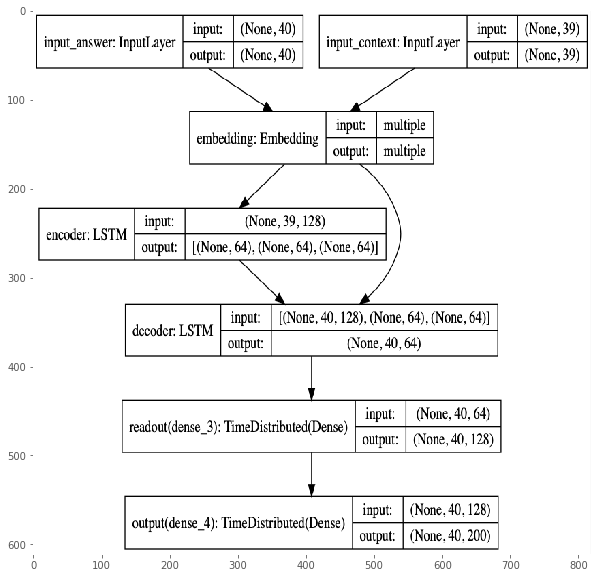

In [147]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plot_model(Chatbot, to_file='Chatbot_model.png', show_shapes=True)

img = mpimg.imread('Chatbot_model.png')
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img, interpolation='nearest')
ax.set_aspect('auto')
plt.show()